In [ ]:
!pip install transformers

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alessiocorrado99/animals10
!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving

In [ ]:
! unzip animals10.zip

In [ ]:
! unzip art-images-drawings-painting-sculpture-engraving.zip

In [105]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import random

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [ ]:
# initialise tokeniser (Download vocabulary from huggingface.co)
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def tokenise(sentence):
  
  tensor = tf.constant(tokenizer(sentence)['input_ids'])
  arr = tensor.numpy()
  dim = 500 * 522 * 3
  mul = (dim // arr.shape[0]) + 1
  arr = np.repeat(arr, mul)
  arr = arr[:dim]
  arr = np.random.permutation(arr)
  tensor = tf.constant(arr)
  tensor = tf.reshape(tensor, ([500,522,3])) 
  tiled_tensor = tensor % 255

  img = tensor_to_image(tiled_tensor)
  return tiled_tensor, img

In [118]:
def load_img(path_to_img):
  parent_folder = os.listdir(path_to_img)
  folder = random.choice(parent_folder)
  path = path_to_img + "/" + folder
  images = os.listdir(path)
  img = random.choice(images)
  path_to_img = path + "/" + img

  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [119]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [134]:
def generate_art():
  stylized_image = hub_model(questionable_style_image, tf.constant(style_image))[0]
  alien_splatter = hub_model(tf.constant(content_image), stylized_image)[0]
  return alien_splatter

In [138]:
sentence = "Name: John Doe, School: SUTD, LinkedIn: https://www.linkedin.com/in/johndoe/, Github: https://github.com/johndoe, Resume: XXX"
tiled_tensor, img = tokenise(sentence)


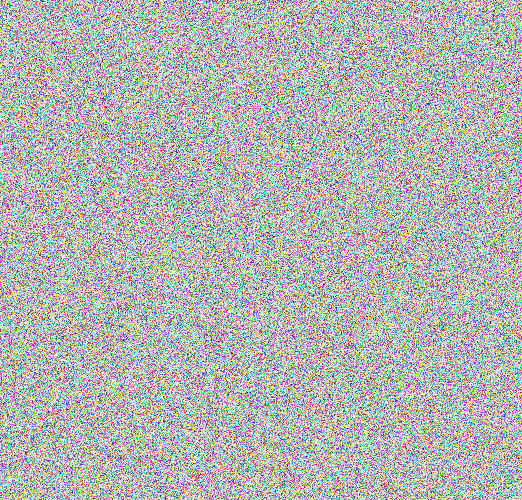

In [142]:
tensor_to_image(tiled_tensor)

In [ ]:
questionable_style_image = tf.cast(tf.reshape(tiled_tensor, [1] + tiled_tensor.shape), tf.float32)

In [139]:
content_path = "/content/raw-img"
style_path = "/content/musemart/dataset_updated/training_set"

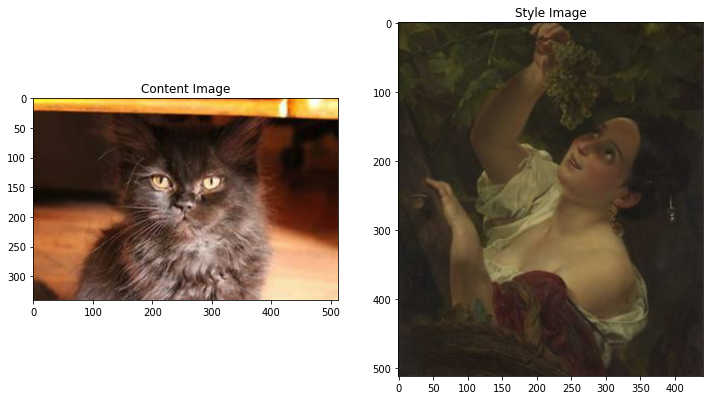

In [140]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

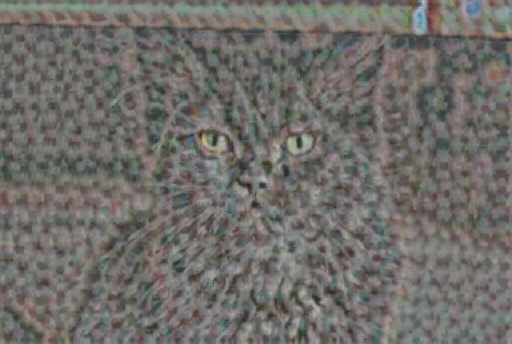

In [141]:
art = generate_art()
tensor_to_image(art)

In [ ]:
# def generate_png(alien_splatter):
#    t = tf.reshape(alien_splatter, [488, 512, 3])
#    t = tf.cast(t, tf.uint16)
#    img = tf.io.encode_png(t, compression=-1, name=None)
#    return img